In [1]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

# see also https://quantumcomputing.stackexchange.com/questions/29007/solve-sudoku-using-grovers-algorithm 

import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

In [2]:
# if necessary
# %pip install qiskit_aer

In [3]:
import numpy as np

import qiskit
#from qiskit import IBMQ, Aer, transpile, execute
from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
#from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library.standard_gates import XGate, ZGate
#from qiskit.circuit.library import MCMT
#from qiskit.circuit.library.generalized_gates import MCMTGate

from qiskit_aer import AerSimulator


# import basic plot tools
from qiskit.visualization import plot_histogram


qiskit.version.get_version_info()

'1.1.0'

In [4]:
clause_list = [[0,1],
               [2,3],
               [0,2],
               [1,3],
               [4,5],
               [6,7],
               [4,6],
               [5,7]]

In [5]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [ ]:
def diffuser(nqubits, cqb):
    qcirc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qcirc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qcirc.x(qubit)
    # Do multi-controlled-Z gate
    qcirc.h(nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    c3z = ZGate().control(num_ctrl_qubits=3, ctrl_state='111')
    qcirc.append(c3z, [0,1,2,3])
    # this will support the call from cell 11: qc.append(diffuser(4), [0,1,2,3])


    qcirc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qcirc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qcirc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qcirc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [7]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
           │       
input_1: ──┼────■──
         ┌─┴─┐┌─┴─┐
 output: ┤ X ├┤ X ├
         └───┘└───┘

In [8]:
# Create separate registers to name bits
var_qubits = QuantumRegister(8, name='v')  # variable bits
clause_qubits = QuantumRegister(8, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

»
v_0: ──■─────────────────────────────■─────────────────────────────────────»
       │                             │                                     »
v_1: ──┼───────────────────■─────────┼────────────────────────■────────────»
       │                   │         │                        │            »
v_2: ──┼────■──────────────┼─────────┼───────────────────■────┼────────────»
       │    │              │         │                   │    │            »
v_3: ──┼────┼──────────────┼────■────┼───────────────────┼────┼────────────»
       │    │              │    │    │                   │    │            »
v_4: ──┼────┼────■─────────┼────┼────┼──────────────■────┼────┼────────────»
       │    │    │         │    │    │              │    │    │            »
v_5: ──┼────┼────┼─────────┼────┼────┼────■─────────┼────┼────┼─────────■──»
       │    │    │         │    │    │    │         │    │    │         │  »
v_6: ──┼────┼────┼────■────┼────┼────┼────┼─────────┼────┼────┼────■────┼──»
       │    │    │    │    │    │    │    │         │    │    │    │    │  »
v_7: ──┼────┼────┼────┼────┼────┼────┼────┼────■────┼────┼────┼────┼────┼──»
     ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │    │    │    │    │    │    │  »
c_0: ┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──»
     └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │    │    │    │    │    │    │    │  »
c_1: ─────┤ X ├──┼────┼───────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──»
          └───┘  │    │       └───┘┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │  »
c_2: ────────────┼────┼────────────┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──»
                 │    │            └───┘  │    │    │  └───┘┌─┴─┐  │    │  »
c_3: ────────────┼────┼───────────────────┼────┼────┼───────┤ X ├──┼────┼──»
               ┌─┴─┐  │                 ┌─┴─┐  │    │       └───┘  │    │  »
c_4: ──────────┤ X ├──┼─────────────────┤ X ├──┼────┼──────────────┼────┼──»
               └───┘┌─┴─┐               └───┘┌─┴─┐  │              │    │  »
c_5: ───────────────┤ X ├────────────────────┤ X ├──┼──────────────┼────┼──»
                    └───┘                    └───┘┌─┴─┐          ┌─┴─┐  │  »
c_6: ─────────────────────────────────────────────┤ X ├──────────┤ X ├──┼──»
                                                  └───┘          └───┘┌─┴─┐»
c_7: ─────────────────────────────────────────────────────────────────┤ X ├»
                                                                      └───┘»
«               
«v_0: ──────────
«               
«v_1: ──────────
«               
«v_2: ──────────
«               
«v_3: ──■───────
«       │       
«v_4: ──┼───────
«       │       
«v_5: ──┼───────
«       │       
«v_6: ──┼───────
«       │       
«v_7: ──┼────■──
«       │    │  
«c_0: ──┼────┼──
«       │    │  
«c_1: ──┼────┼──
«       │    │  
«c_2: ──┼────┼──
«     ┌─┴─┐  │  
«c_3: ┤ X ├──┼──
«     └───┘  │  
«c_4: ───────┼──
«            │  
«c_5: ───────┼──
«            │  
«c_6: ───────┼──
«          ┌─┴─┐
«c_7: ─────┤ X ├
«          └───┘

In [9]:
# Create separate registers to name bits
var_qubits = QuantumRegister(8, name='v')
clause_qubits = QuantumRegister(8, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
# MCT = multi-controlled Toffoli gate
#qc.mct(clause_qubits, output_qubit)
#qc.MCMTGate(XGate(), len(clause_qubits), len(output_qubit))
c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
qc.append(c3z, [8,9,10,11,16])
c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
qc.append(c3z, [12,13,14,15,16])
#c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
#qc.append(c3z, [4,5,6,7,8])

qc.draw()

»
v_0: ──■─────────────────────────────■─────────────────────────────────────»
       │                             │                                     »
v_1: ──┼───────────────────■─────────┼────────────────────────■────────────»
       │                   │         │                        │            »
v_2: ──┼────■──────────────┼─────────┼───────────────────■────┼────────────»
       │    │              │         │                   │    │            »
v_3: ──┼────┼──────────────┼────■────┼───────────────────┼────┼────────────»
       │    │              │    │    │                   │    │            »
v_4: ──┼────┼────■─────────┼────┼────┼──────────────■────┼────┼────────────»
       │    │    │         │    │    │              │    │    │            »
v_5: ──┼────┼────┼─────────┼────┼────┼────■─────────┼────┼────┼─────────■──»
       │    │    │         │    │    │    │         │    │    │         │  »
v_6: ──┼────┼────┼────■────┼────┼────┼────┼─────────┼────┼────┼────■────┼──»
       │    │    │    │    │    │    │    │         │    │    │    │    │  »
v_7: ──┼────┼────┼────┼────┼────┼────┼────┼────■────┼────┼────┼────┼────┼──»
     ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │    │    │    │    │    │    │  »
c_0: ┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──»
     └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │    │    │    │    │    │    │    │  »
c_1: ─────┤ X ├──┼────┼───────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──»
          └───┘  │    │       └───┘┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │  »
c_2: ────────────┼────┼────────────┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──»
                 │    │            └───┘  │    │    │  └───┘┌─┴─┐  │    │  »
c_3: ────────────┼────┼───────────────────┼────┼────┼───────┤ X ├──┼────┼──»
               ┌─┴─┐  │                 ┌─┴─┐  │    │       └───┘  │    │  »
c_4: ──────────┤ X ├──┼─────────────────┤ X ├──┼────┼──────────────┼────┼──»
               └───┘┌─┴─┐               └───┘┌─┴─┐  │              │    │  »
c_5: ───────────────┤ X ├────────────────────┤ X ├──┼──────────────┼────┼──»
                    └───┘                    └───┘┌─┴─┐          ┌─┴─┐  │  »
c_6: ─────────────────────────────────────────────┤ X ├──────────┤ X ├──┼──»
                                                  └───┘          └───┘┌─┴─┐»
c_7: ─────────────────────────────────────────────────────────────────┤ X ├»
                                                                      └───┘»
out: ──────────────────────────────────────────────────────────────────────»
                                                                           »
«                     
«v_0: ────────────────
«                     
«v_1: ────────────────
«                     
«v_2: ────────────────
«                     
«v_3: ──■─────────────
«       │             
«v_4: ──┼─────────────
«       │             
«v_5: ──┼─────────────
«       │             
«v_6: ──┼─────────────
«       │             
«v_7: ──┼────■────────
«       │    │        
«c_0: ──┼────┼───■────
«       │    │   │    
«c_1: ──┼────┼───■────
«       │    │   │    
«c_2: ──┼────┼───■────
«     ┌─┴─┐  │   │    
«c_3: ┤ X ├──┼───■────
«     └───┘  │   │    
«c_4: ───────┼───┼──■─
«            │   │  │ 
«c_5: ───────┼───┼──■─
«            │   │  │ 
«c_6: ───────┼───┼──■─
«          ┌─┴─┐ │  │ 
«c_7: ─────┤ X ├─┼──■─
«          └───┘ │  │ 
«out: ───────────■──■─
«

In [10]:
var_qubits = QuantumRegister(8, name='v')
clause_qubits = QuantumRegister(8, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    #qc.mct(clause_qubits, output_qubit)
    c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
    qc.append(c3z, [8,9,10,11,16])
    c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
    qc.append(c3z, [12,13,14,15,16])
    #c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
    #qc.append(c3z, [4,5,6,7,8])


    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()


»
    v_0: ──■─────────────────────────────■─────────────────────────────────────»
           │                             │                                     »
    v_1: ──┼───────────────────■─────────┼────────────────────────■────────────»
           │                   │         │                        │            »
    v_2: ──┼────■──────────────┼─────────┼───────────────────■────┼────────────»
           │    │              │         │                   │    │            »
    v_3: ──┼────┼──────────────┼────■────┼───────────────────┼────┼────────────»
           │    │              │    │    │                   │    │            »
    v_4: ──┼────┼────■─────────┼────┼────┼──────────────■────┼────┼────────────»
           │    │    │         │    │    │              │    │    │            »
    v_5: ──┼────┼────┼─────────┼────┼────┼────■─────────┼────┼────┼─────────■──»
           │    │    │         │    │    │    │         │    │    │         │  »
    v_6: ──┼────┼────┼────■────┼────┼────┼────┼─────────┼────┼────┼────■────┼──»
           │    │    │    │    │    │    │    │         │    │    │    │    │  »
    v_7: ──┼────┼────┼────┼────┼────┼────┼────┼────■────┼────┼────┼────┼────┼──»
         ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │    │    │    │    │    │    │  »
    c_0: ┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──»
         └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │    │    │    │    │    │    │    │  »
    c_1: ─────┤ X ├──┼────┼───────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼──»
              └───┘  │    │       └───┘┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │  »
    c_2: ────────────┼────┼────────────┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──»
                     │    │            └───┘  │    │    │  └───┘┌─┴─┐  │    │  »
    c_3: ────────────┼────┼───────────────────┼────┼────┼───────┤ X ├──┼────┼──»
                   ┌─┴─┐  │                 ┌─┴─┐  │    │       └───┘  │    │  »
    c_4: ──────────┤ X ├──┼─────────────────┤ X ├──┼────┼──────────────┼────┼──»
                   └───┘┌─┴─┐               └───┘┌─┴─┐  │              │    │  »
    c_5: ───────────────┤ X ├────────────────────┤ X ├──┼──────────────┼────┼──»
                        └───┘                    └───┘┌─┴─┐          ┌─┴─┐  │  »
    c_6: ─────────────────────────────────────────────┤ X ├──────────┤ X ├──┼──»
                                                      └───┘          └───┘┌─┴─┐»
    c_7: ─────────────────────────────────────────────────────────────────┤ X ├»
                                                                          └───┘»
    out: ──────────────────────────────────────────────────────────────────────»
                                                                               »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                             »
«    v_0: ───────────────■───────────────────■────────────────────────────────»
«                        │                   │                                »
«    v_1: ───────────────┼─────────■─────────┼───────────────────■────────────»
«                        │         │         │                   │            »
«    v_2: ───────────────┼────■────┼─────────┼──────────────■────┼────────────»
«                        │    │    │         │              │    │            »
«    v_3: ──■────────────┼────┼────┼────■────┼──────────────┼────┼────────────»
«           │            │    │    │    │    │              │    │            »
«    v_4: ──┼────────────┼────┼────┼────┼────┼────■─────────┼────┼────────────»
«           │            │    │    │    │    │    │         │    │            »
«    v_5: ──┼────────────┼────┼────┼────┼────┼────┼─────────┼────┼────■───────»
«           │            │    │    │    │    │    │         │    │    │       »
«    v_6: ──┼────────────┼────┼────┼────┼─

In [ ]:
# full algorithm

var_qubits = QuantumRegister(8, name='v')
clause_qubits = QuantumRegister(8, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(8, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4,0), [0,1,2,3])
qc.append(diffuser(4,4), [4,5,6,7])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4,0), [0,1,2,3])
qc.append(diffuser(4,4), [4,5,6,7])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                                                                                                     ░ ┌────────┐                                                                                                                                                               ░ ┌────────┐         ┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────────────────────────■────────────────────────────────────────────────────■───────────────────■──────────────────────────────────────────────────────────░─┤0       ├───────■──────────────────────────────────■─────────────────────────────────────■───────────────────■──────────────────────────────────────────────────────────░─┤0       ├─────────┤M├─────────
                      ├───┤               ░   │                             │                                                    │                   │                                                          ░ │        │       │                                  │                                     │                   │                                                          ░ │        │         └╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼───────────────────■─────────┼────────────────────────■───────────────────────────┼─────────■─────────┼───────────────────■──────────────────────────────────────░─┤1       ├───────┼────────────────────────■─────────┼───────────────────■─────────────────┼─────────■─────────┼───────────────────■──────────────────────────────────────░─┤1       ├──────────╫─┤M├──────
                      ├───┤               ░   │                   │         │                        │                           │         │         │                   │                                      ░ │  U$_s$ │       │                        │         │                   │                 │         │         │                   │                                      ░ │  U$_s$ │          ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────■──────────────┼─────────┼───────────────────■────┼───────────────────────────┼────■────┼─────────┼──────────────■────┼──────────────────────────────────────░─┤2       ├───────┼────■───────────────────┼─────────┼──────────────■────┼─────────────────┼────■────┼─────────┼──────────────■────┼──────────────────────────────────────░─┤2       ├──────────╫──╫─┤M├───
                      ├───┤               ░   │    │              │         │                   │    │                           │    │    │         │              │    │                                      ░ │        │       │    │                   │         │              │    │                 │    │    │         │              │    │                                      ░ │        │          ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼──────────────┼────■────┼───────────────────┼────┼──────────────■────────────┼────┼────┼────■────┼──────────────┼────┼───────────────────■──────────────────░─┤3       ├───────┼────┼───────────────────┼────■────┼──────────────┼────┼─────────■───────┼────┼────┼────■────┼──────────────┼────┼───────────────────■──────────────────░─┤3       ├──────────╫──╫──╫─┤M├
                      ├───┤               ░   │    │              │    │    │                   │    │              │            │    │    │    │    │              │    │                   │                  ░ └────────┘       │    │                   │    │    │              │    │         │       │    │    │    │    │              │    │                   │                  ░ └──┬─┬───┘          ║  ║  ║ └╥┘
    v_4: ─────────────┤ H ├───────────────░───┼────┼────■─────────┼────┼────┼──────────────■────┼────┼──────────────┼────────────┼────┼────┼────┼────┼────■─────────┼────┼──────────────■────┼──────────────────░─────■────────────┼────┼──────────────■────┼────┼────┼──────────────┼────┼─────────┼───────┼────

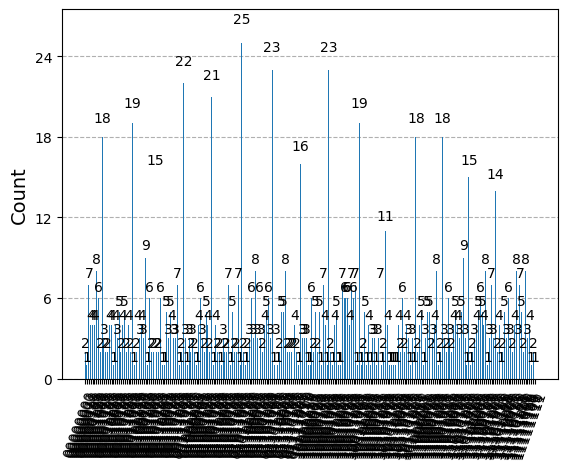

In [13]:
# Simulate and plot results
simulator = AerSimulator() #qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc =  transpile(qc, simulator) #transpiled_qc = transpile(qc, qasm_simulator)
result = simulator.run(transpiled_qc).result() #result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [ ]:
# DEAD CODE

def dead_diffuser(nqubits, cqb):
    qcirc = QuantumCircuit(nqubits+cqb)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(cqb,nqubits+cqb):
        qcirc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(cqb,nqubits+cqb):
        qcirc.x(qubit)
    # Do multi-controlled-Z gate
    qcirc.h(cqb+nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    c3z = ZGate().control(num_ctrl_qubits=3, ctrl_state='111')
    qcirc.append(c3z, [cqb,cqb+1,cqb+2,cqb+3])
    # this will support the call: qc.append(diffuser(4), [0,1,2,3])


    qcirc.h(cqb+nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(cqb,nqubits+cqb):
        qcirc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(cqb,nqubits+cqb):
        qcirc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qcirc.to_gate()
    U_s.name = "U$_s$"
    return U_s